In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

import seaborn as sns
from sklearn.metrics import confusion_matrix

/home/smithtape/anaconda3/envs/envtwo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the CNN model

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
                        nn.BatchNorm2d(4),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=2))
        self.fc = nn.Sequential(
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=3*3*64, out_features=128),
                        nn.BatchNorm1d(128),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=128, out_features=32),
                        nn.BatchNorm1d(32),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=32, out_features=10))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view((x.shape[0],-1))
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [3]:
# Initialize transformations and data loaders

batch_size = 96

# Using mean and std of MNIST from torchvision
train_mean = (0.5,)
train_std = (0.5,)

train_transform = transforms.Compose(
                    [
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=train_mean, std=train_std),
                    ])

val_transform = transforms.Compose(
                    [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=train_mean, std=train_std),
                    ])

train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = datasets.MNIST(root='./data', train=False, transform=val_transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:01<00:00, 6374122.51it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7210457.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1896943.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17381869.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



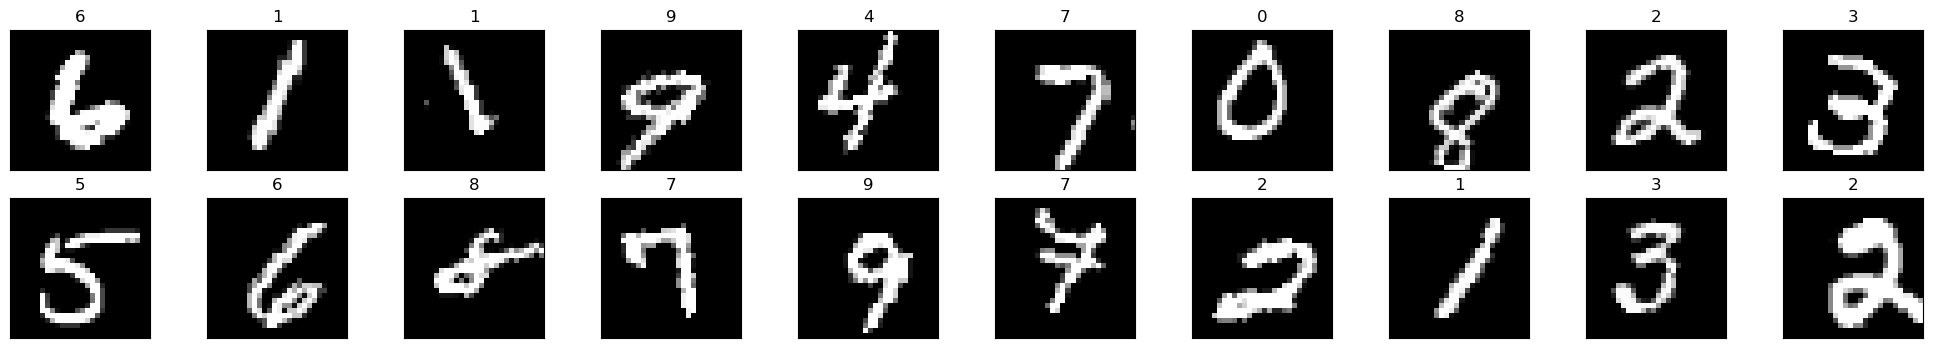

In [4]:
# Get one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img, cmap="gray")

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].squeeze())
    ax.set_title(labels[idx].item())

plt.show()

In [5]:
# Define the training loop

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [6]:
# Define the evaluation function

def evaluate(model, device, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / len(loader.dataset)
    return avg_loss, accuracy

In [7]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

num_epochs = 100
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    val_loss, val_accuracy = evaluate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch: 1, Train Loss: 0.8929, Val Loss: 0.0919, Val Accuracy: 97.27%
Epoch: 2, Train Loss: 0.3107, Val Loss: 0.0540, Val Accuracy: 98.28%
Epoch: 3, Train Loss: 0.2297, Val Loss: 0.0408, Val Accuracy: 98.69%
Epoch: 4, Train Loss: 0.1967, Val Loss: 0.0384, Val Accuracy: 98.70%
Epoch: 5, Train Loss: 0.1747, Val Loss: 0.0357, Val Accuracy: 98.78%
Epoch: 6, Train Loss: 0.1609, Val Loss: 0.0329, Val Accuracy: 98.89%
Epoch: 7, Train Loss: 0.1548, Val Loss: 0.0274, Val Accuracy: 99.10%
Epoch: 8, Train Loss: 0.1423, Val Loss: 0.0284, Val Accuracy: 99.07%
Epoch: 9, Train Loss: 0.1418, Val Loss: 0.0275, Val Accuracy: 99.08%
Epoch: 10, Train Loss: 0.1338, Val Loss: 0.0260, Val Accuracy: 99.13%
Epoch: 11, Train Loss: 0.1310, Val Loss: 0.0272, Val Accuracy: 99.14%
Epoch: 12, Train Loss: 0.1309, Val Loss: 0.0279, Val Accuracy: 99.08%
Epoch: 13, Train Loss: 0.1214, Val Loss: 0.0289, Val Accuracy: 99.10%
Epoch: 14, Train Loss: 0.1204, Val Loss: 0.0240, Val Accuracy: 99.07%
Epoch: 15, Train Loss: 0.1188

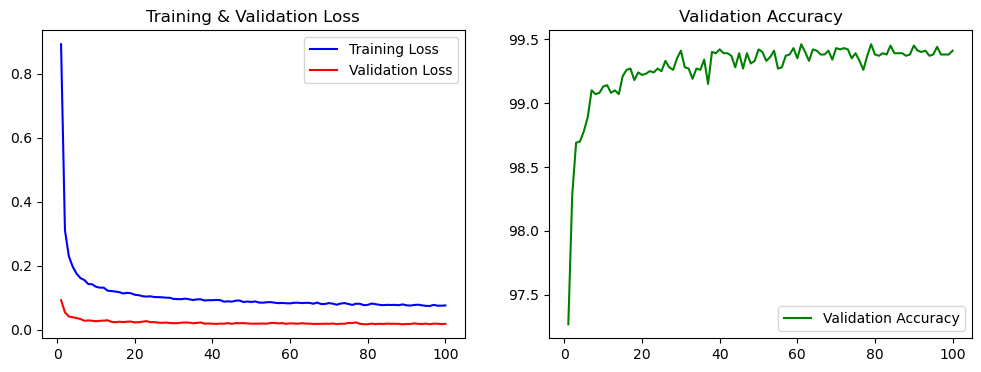

In [8]:
# Plot training and validation curves

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, 'g-', label='Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [9]:
# Evaluate the model using the test set

def get_all_preds_and_targets(model, device, loader):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

def get_probs_and_targets(model, device, loader):
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    return np.array(all_probs), np.array(all_targets)

# Get all predictions and targets
all_preds, all_targets = get_all_preds_and_targets(model, device, val_loader)

# Compute Precision, Recall, and F1-score
precision = precision_score(all_targets, all_preds, average='macro')
recall = recall_score(all_targets, all_preds, average='macro')
f1 = f1_score(all_targets, all_preds, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_mat = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(conf_mat)

# AUC-ROC (Computed for each class using One-vs-All approach, and then averaged)
all_probs, _ = get_probs_and_targets(model, device, val_loader)
roc_auc = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='macro')
print(f"AUC-ROC: {roc_auc:.4f}")

# Log-Loss
logloss = log_loss(all_targets, all_probs)
print(f"Log Loss: {logloss:.4f}")


Precision: 0.9941
Recall: 0.9940
F1 Score: 0.9940
Confusion Matrix:
[[ 976    0    2    0    0    0    1    1    0    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   1    0 1029    0    0    0    0    2    0    0]
 [   0    1    1 1004    0    1    0    1    1    1]
 [   0    0    1    0  978    0    1    0    0    2]
 [   1    0    0    4    0  883    3    0    0    1]
 [   1    1    1    0    0    1  953    0    1    0]
 [   0    2    2    0    1    0    0 1022    0    1]
 [   1    1    2    0    1    1    0    0  965    3]
 [   0    0    0    0    8    2    0    2    0  997]]
AUC-ROC: 1.0000
Log Loss: 0.0180


/home/smithtape/anaconda3/envs/envtwo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


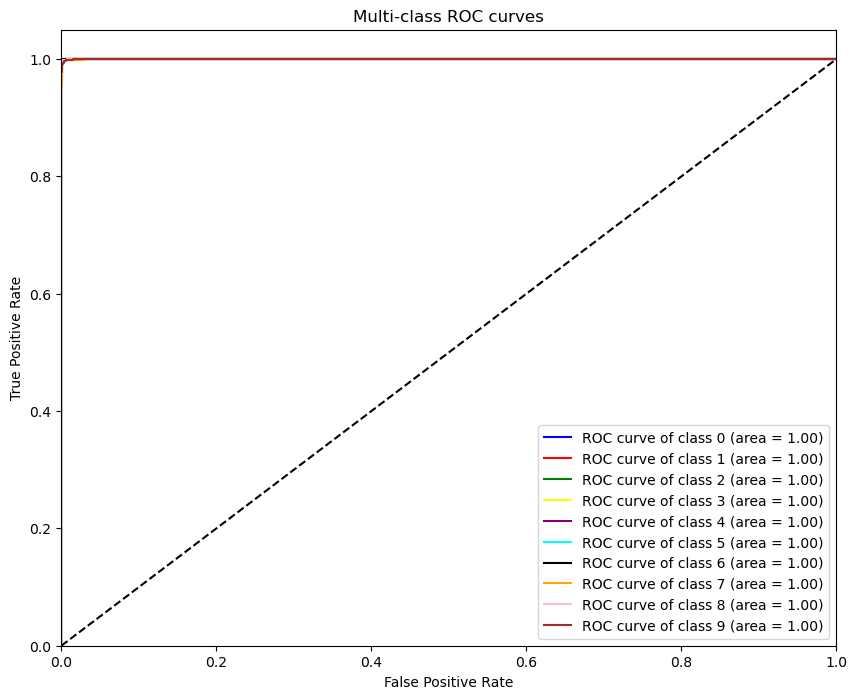

In [10]:
# Earlier you had get_probs_and_targets function
all_probs, all_targets = get_probs_and_targets(model, device, val_loader)

# Convert the targets to one-hot encoding
all_targets_onehot = np.eye(10)[all_targets]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(all_targets_onehot[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'yellow', 'purple', 'cyan', 'black', 'orange', 'pink', 'brown']
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()


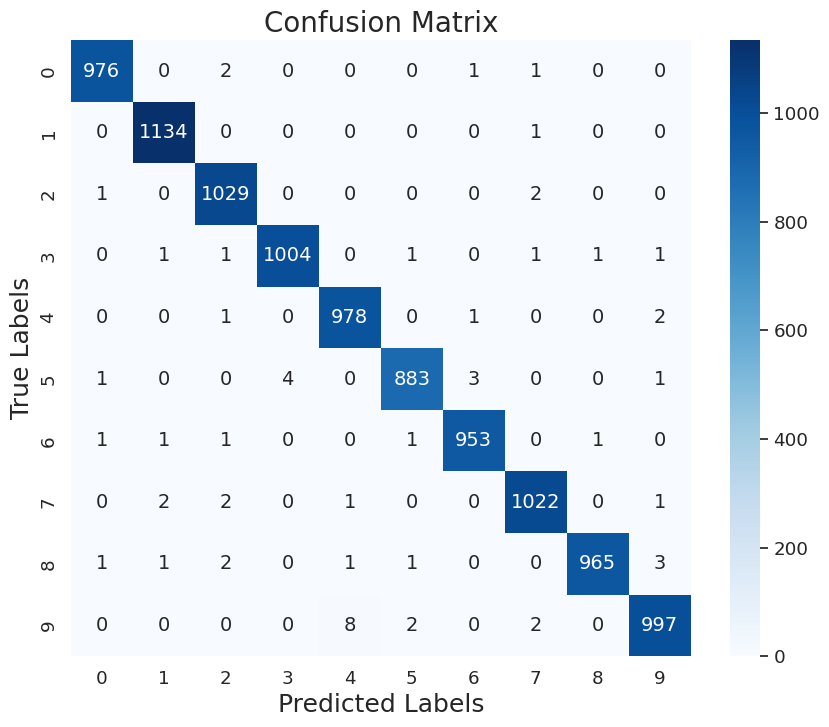

In [11]:
# Assuming all_preds and all_targets from previous steps
conf_mat = confusion_matrix(all_targets, all_preds)
classes = [str(i) for i in range(10)]
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # for label size
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='g', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Labels', fontsize=18)
plt.ylabel('True Labels', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)
plt.show()
